# Level-set method
***

## Introduction
The level-set method is a method designed for modeling material interaction. The main idea is based on a function $l$, which satisfies the following.

$$ l(x) \begin{cases}
         > 0 \text{ if } x \in \Omega_1 \\
         < 0 \text{ in } x \in \Omega_2
    \end{cases}. $$

We will focus only on the interaction between two incompressible Navier-Stokes equations with different
constant parameters $\rho_i, \mu_i \in \Omega_i$ for $i  \in  \{ 1, 2 \}$. The function $l$ allows us to define
viscosity $\mu$ and density $\rho$ in the whole domain $\Omega$ as a single
function
\begin{equation*}
    \mu(l) = \frac{1}{2}(\text{sign}(l) + 1)\mu_1 + \frac{1}{2}(\text{sign}(l) - 1) \mu_2
\end{equation*}
and
\begin{equation*}
    \rho(l) = \frac{1}{2}(\text{sign}(l) + 1)\rho_1 + \frac{1}{2}(\text{sign}(l) - 1) \rho_2.
\end{equation*}
Because we would like to solve the evolution problem, the $\Omega_i$ and the function $l$
have to depend on time. We want $l$ to be constant along streamlines for the prescribed velocity field $v$.
This condition is satisfied if
$$ \partial_t l(x, t) + \text{div}(l(x, t) v(x,  t)) = 0. $$
We can now formulate the whole system, firstly in the strong sense.
$$ \rho(l) \left( \partial_t v + (v \cdot \nabla) v \right)  = \text{div}\left(\mathbb{T}(\mu(l), \nabla v)\right) + \rho(l)g,$$

$$ \mathbb{T}(\mu(l), \nabla v) = \mu(l)\left( \nabla v + (\nabla v)^T \right) - p\mathbb{I}, $$

$$ \partial_t l + \text{div}(l v) = 0, $$

$$ \text{div}(v) = 0. $$

## Rayleigh-Taylor Example
Let us assume a rectangular domain with two fluids as it is desctibed in the figure below. We will cosidere Navier-Stokes fluid for both of them.
The fluids will stick on the boundary of the domain, so $v = 0$ at $\partial \Omega$.
<div align=center>
<img src="pics/rt.png" width="200"/>
</div>

## Implementation

In [1]:
import dolfin as df
import matplotlib.pyplot as plt

Then we define the mesh.

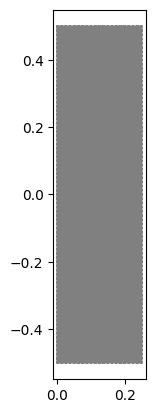

In [2]:
mesh = df.RectangleMesh(
        df.Point(0.0, -0.5), df.Point(0.25, 0.5), 20, 80, 'crossed'
)
df.plot(mesh)
plt.show()

We define the initial conditions for velocity and levelset. 

In [3]:
class InitialCondition(df.UserExpression):

    def __init__(self, **kwargs):
        self.center = [0.125, 0.25]
        self.radius = df.sqrt(0.125**2 + 0.25**2)
        super().__init__(**kwargs)
    
    def r(self, x: list) -> float:
        return df.sqrt((x[0] - self.center[0])**2 + (x[1] - self.center[1])**2)

    def eval(self, values, x):
        values[0] = 0.0  # v_x
        values[1] = 0.0  # v_y
        values[2] = 0.0  # p
        values[3] = self.r(x) - self.radius  # l

    def value_shape(self):
        return (4, )
# create instance of the class.
# initial_conditions = InitialCondition()


class InitialConditionSigmoid(df.UserExpression):

    def __init__(self, **kwargs):
        self.center = [0.125, 0.25]
        self.radius = df.sqrt(0.125**2 + 0.25**2)
        self.eps = 0.001 
        super().__init__(**kwargs)
    
    def r(self, x: list) -> float:
        return df.sqrt((x[0] - self.center[0])**2 + (x[1] - self.center[1])**2)

    def eval(self, values, x):
        values[0] = 0.0  # v_x
        values[1] = 0.0  # v_y
        values[2] = 0.0  # p
        values[3] = 1 / (1 + df.exp(min((self.radius - self.r(x) ) / self.eps, 10)))
        # values[3] = 1 / (df.exp( (self.r(x) - self.radius) / self.eps ))

    def value_shape(self):
        return (4, )

initial_conditions = InitialConditionSigmoid()

Then we define approximation of the signum function as
\begin{equation}
    \text{sign}(l) = \frac{l}{\sqrt(l^2 + \varepsilon^2\nabla l \cdot \nabla l)} 
\end{equation}

In [4]:
# def sign(q: df.Function, eps: float):
#    return q / df.sqrt(q * q + eps * eps * df.inner(df.grad(q), df.grad(q)))

def sign(q: df.Function, eps: float):
   return 2 * (q - 0.5)  

Further we create the function spaces. We use "CG" for each subspace.

In [5]:
elements = [
    df.VectorElement("CG", mesh.ufl_cell(), 2), # velocity
    df.FiniteElement("CG", mesh.ufl_cell(), 1), # pressure
    df.FiniteElement("CG", mesh.ufl_cell(), 1)  # levelset
]

function_space = df.FunctionSpace(
    mesh, df.MixedElement(elements)
)

Now we define all the constants. 

In [6]:
material_params = {
    "mu1": 1.0,
    "mu2": 1.0,
    "rho1": 500,
    "rho2": 1000,
}
eps = 1e-4
dt = 0.02
t_start = 0.0
t_end = 1.0
g = df.Constant((0.0, -10.0)) # gravity field

Further, we create the boundary conditions for velocity. In particular we 
require that $v = 0$ on the whole boundary of the domain.

In [7]:
bcs = [
    df.DirichletBC(
        function_space.sub(0),  # v
        df.Constant((0.0, 0.0)),
        "on_boundary"
    )
]

Now we define the funcions on our space and interpolate the initial condition on the space.

In [8]:
w = df.Function(function_space)  # unknown
w0 = df.Function(function_space)  # from previous step
phi = df.TestFunction(function_space) # test function
w0.assign(df.interpolate(initial_conditions, function_space))
w.assign(w0)

# Split functions
v, p, l = df.split(w)
v0, p0, l0 = df.split(w0)
phi_v, phi_p, phi_l = df.split(phi)

We will need to formulate the functions $\rho$ and $\mu$. 

In [9]:
def rho(params: dict, l: df.Function, eps: float, sign):
   return (
        params["rho1"] * 0.5* (1.0 + sign(l, eps))
        + params["rho2"] * 0.5 * (1.0 - sign(l, eps))
    )


def mu(params: dict, l: df.Function, eps: float, sign):
   return (
        params["mu1"] * 0.5 * (1.0 + sign(l, eps))
        + params["mu2"] * 0.5 * (1.0 - sign(l, eps))
    )

It is time to write down the equations.
\begin{equation*}
  \mathbb{T} = \mu (\nabla v + (\nabla v)^T) - p \mathbb{I} 
\end{equation*}

\begin{equation*}
   \int_{\Omega} \rho \partial_t v \cdot \varphi_{v} + \rho ((\nabla v) v) \cdot \varphi_v \; dx + \int_{\Omega} \mathbb{T} \cdot \nabla \varphi_{v}\; dx = 0
\end{equation*}

\begin{equation*}
  \int_{\Omega} \text{div}(v)\varphi_p \; dx = 0
\end{equation*}

\begin{equation*}
  \int_{\Omega} (\partial_t l) \varphi_l + \text{div}(l v) \varphi_l \;dx = 0 
\end{equation*}

In [10]:
n = df.FacetNormal(mesh)
h = df.CellDiameter(mesh)
h_avg = (h('+') + h('-')) / 2.0
alpha = df.Constant(0.1)

cauchy_green = (
    mu(material_params, l, eps, sign) * (df.grad(v) + df.grad(v).T)
    - p * df.Identity(mesh.topology().dim())
)

material_detivative = (
    (1 / dt) * df.inner(v - v0, phi_v)  # partial time derivative
    + df.inner(df.grad(v) * v, phi_v)  # convective therm
)

momentum = (
    rho(material_params, l, eps, sign) * material_detivative*df.dx
    + df.inner(cauchy_green, df.grad(phi_v))*df.dx
    - rho(material_params, l, eps, sign)
    * df.inner(g, phi_v) * df.dx
)

mass = (
    df.div(v) * phi_p*df.dx
)

levelset_convection = (
    (1 / dt) * df.inner(l - l0, phi_l) * df.dx
    + df.div(l * v) * phi_l * df.dx
)

stabilization = (
    alpha('+') * (h_avg**2)
    * df.inner(df.jump(df.grad(l), n), df.jump(df.grad(phi_l), n)) * df.dS
)

pde_form = momentum + mass + levelset_convection + stabilization

Our system is not linear, thus we need to solve it with Newton solver. Let's define it now!

In [11]:
# Set Newton-solver
# form compiler parameter
ffc_options = {
    "quadrature_degree": 4,
    "optimize": True,
    "eliminate_zeros": True
}

J = df.derivative(pde_form, w)
problem = df.NonlinearVariationalProblem(pde_form, w, bcs, J, ffc_options)
solver = df.NonlinearVariationalSolver(problem)

prm = solver.parameters
prm['nonlinear_solver'] = 'newton'
prm['newton_solver']['linear_solver'] = 'mumps'
prm['newton_solver']['lu_solver']['report'] = False
prm['newton_solver']['absolute_tolerance'] = 1E-10
prm['newton_solver']['relative_tolerance'] = 1E-10
prm['newton_solver']['maximum_iterations'] = 20
prm['newton_solver']['report'] = True

We create the XDMF files for storing the results.

In [12]:
# Initialize the files for writing the results
files = []
for name in ['v', 'p', 'l']:
    with df.XDMFFile(df.MPI.comm_world, f"result/{name}.xdmf") as xdmf:
        xdmf.parameters["flush_output"] = True
        files.append(xdmf)

It remains to solve it!!

In [13]:
t = t_start
while t < t_end:
    df.info(f"t = {t}")
    solver.solve()
    w0.assign(w)
    t += dt
    # write the time-step into the file
    for func, name, xdmf in zip(w.split(True), ['v', 'p', 'l'], files):
        func.rename(name, name)
        xdmf.write(func, t)

t = 0.0
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 2.030e+01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-10)
  Newton iteration 1: r (abs) = 1.748e-02 (tol = 1.000e-10) r (rel) = 8.611e-04 (tol = 1.000e-10)
  Newton iteration 2: r (abs) = 3.236e-06 (tol = 1.000e-10) r (rel) = 1.594e-07 (tol = 1.000e-10)
  Newton iteration 3: r (abs) = 6.006e-13 (tol = 1.000e-10) r (rel) = 2.959e-14 (tol = 1.000e-10)
  Newton solver finished in 3 iterations and 3 linear solver iterations.
t = 0.02
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 3.325e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-10)
  Newton iteration 1: r (abs) = 6.290e-03 (tol = 1.000e-10) r (rel) = 1.892e-02 (tol = 1.000e-10)
  Newton iteration 2: r (abs) = 3.830e-07 (tol = 1.000e-10) r (rel) = 1.152e-06 (tol = 1.000e-10)
  Newton iteration 3: r (abs) = 4.322e-13 (tol = 1.000e-10) r (rel) = 1.300e-12 (tol = 1.000e-10)
  Newton solver finished in 3 iterations and 3 l